<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


Работу Выполнил:

Rinat Mahmutov

Stepik User ID: 97296748

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
import pandas as pd

from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

import os
import skimage.io

from IPython import get_ipython
from IPython import display  # выводить график обучения в онлайн режиме
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.4)

from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
data.shape

(13143, 64, 64, 3)

In [6]:
data[0]

array([[[0.35718635, 0.25898533, 0.14133827],
        [0.3481474 , 0.2440468 , 0.12927485],
        [0.385589  , 0.26377528, 0.15009861],
        ...,
        [0.3179046 , 0.22740215, 0.15680147],
        [0.29772806, 0.22781384, 0.16267904],
        [0.28537741, 0.22888231, 0.17487745]],

       [[0.37548541, 0.27616422, 0.15900257],
        [0.3834128 , 0.27334942, 0.15995902],
        [0.44578546, 0.32397174, 0.21028359],
        ...,
        [0.31795343, 0.22745098, 0.15683881],
        [0.29557387, 0.22565966, 0.16052485],
        [0.28235294, 0.22585784, 0.16936275]],

       [[0.39228037, 0.28637312, 0.17263519],
        [0.41410654, 0.30096986, 0.18722044],
        [0.50796377, 0.37824659, 0.26470205],
        ...,
        [0.32181468, 0.22751225, 0.15686275],
        [0.29178922, 0.22185106, 0.15824812],
        [0.27280656, 0.21629902, 0.16060049]],

       ...,

       [[0.63524529, 0.64149529, 0.73566176],
        [0.6700741 , 0.66290499, 0.74985352],
        [0.6735926 , 0

In [7]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [8]:
np.moveaxis(data, 3, 1).shape

(13143, 3, 64, 64)

In [9]:
X = np.moveaxis(data, 3, 1)

X_train, X_test, attrs_train, attrs_test = train_test_split(X, attrs, 
                                                            train_size=0.9,
                                                            random_state=42, 
                                                            shuffle=False)

In [10]:
X_train.shape

(11828, 3, 64, 64)

(3, 64, 64)

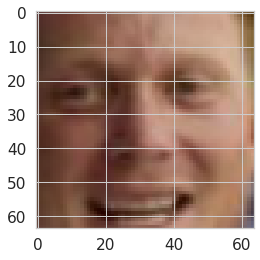

In [11]:
plt.imshow(np.moveaxis(X_train[1], 0, 2))
X_train[0].shape

In [12]:
def img_show(X, cols = 8, rows = 2):
  fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
  for i in range(cols):
    for j in range(rows):
      random_index = np.random.randint(0, len(X))
      ax = fig.add_subplot(rows, cols, i * rows + j + 1)
      ax.grid(False)
      ax.axis('off')
      ax.imshow(np.moveaxis(X[random_index], 0, 2))
  plt.show()

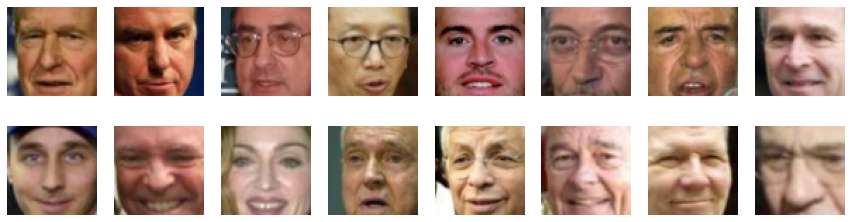

In [13]:
img_show(X_train)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [14]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()

      # encoder
      self.encoder = nn.Sequential(
          nn.Linear(np.prod(input_shape), dim_size*4),
          nn.ReLU(),
          nn.Linear(dim_size*4, dim_size)
          )

      # decoder
      self.decoder = nn.Sequential(
          nn.Linear(dim_size, dim_size*4),
          nn.ReLU(),
          nn.Linear(dim_size*4,  np.prod(input_shape))
      )


    def forward(self, x):
      init_shape = x.shape
      x = torch.flatten(x, 1)
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)
      reconstruction = reconstruction.reshape(init_shape)

      return reconstruction, latent_code


    def sample(self, z):
      gen = self.decoder(z)
      gen = gen.view(-1, 3, 64, 64)
      
      return gen


In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [16]:
def train(model, optimizer, criterion, n_epochs, path=''):
    
    train_loss = []
    val_loss = []
    train_loss_epoch = []
    val_loss_epoch = []

    for epoch in tqdm(range(n_epochs)):
        # обучение
        model.train()
        for X in train_loader:
            batch = X[0].to(device) # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())

        
        # оценка
        model.eval()
        with torch.no_grad():
            for X in test_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch.to(device))

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())


        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 10 == 0:
          print(
              f"После {epoch} эпох, потери на тренировке: {train_loss_epoch[-1]:.6f};   "
              f"потери на валидации: {val_loss_epoch[-1]:.6f}"
          )


        # сохраним модель 
        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pth')

    return model, train_loss_epoch, val_loss_epoch


In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 256

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [18]:
input_shape = X_train.shape[1:]
print(f'форма тренировочного сета: {input_shape}')
print(f'количество пикселей: {np.prod(input_shape)}')

dim_size = 128 # выберите размер латентного вектора

форма тренировочного сета: torch.Size([3, 64, 64])
количество пикселей: 12288


In [19]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [20]:
path = '/content/gdrive/My Drive/autoencoder'

EP0CH = 100

trained_autoencoder, train_losses, val_losses = train(autoencoder, 
                                                    optimizer, 
                                                    criterion, 
                                                    n_epochs=EP0CH, 
                                                    path=path) 

  0%|          | 0/100 [00:00<?, ?it/s]

После 0 эпох, потери на тренировке: 0.126991;   потери на валидации: 0.026650
После 10 эпох, потери на тренировке: 0.024994;   потери на валидации: 0.015556
После 20 эпох, потери на тренировке: 0.017514;   потери на валидации: 0.012569
После 30 эпох, потери на тренировке: 0.014359;   потери на валидации: 0.011025
После 40 эпох, потери на тренировке: 0.012515;   потери на валидации: 0.009999
После 50 эпох, потери на тренировке: 0.011248;   потери на валидации: 0.009235
После 60 эпох, потери на тренировке: 0.010310;   потери на валидации: 0.008638
После 70 эпох, потери на тренировке: 0.009580;   потери на валидации: 0.008154
После 80 эпох, потери на тренировке: 0.008992;   потери на валидации: 0.007752
После 90 эпох, потери на тренировке: 0.008503;   потери на валидации: 0.007409


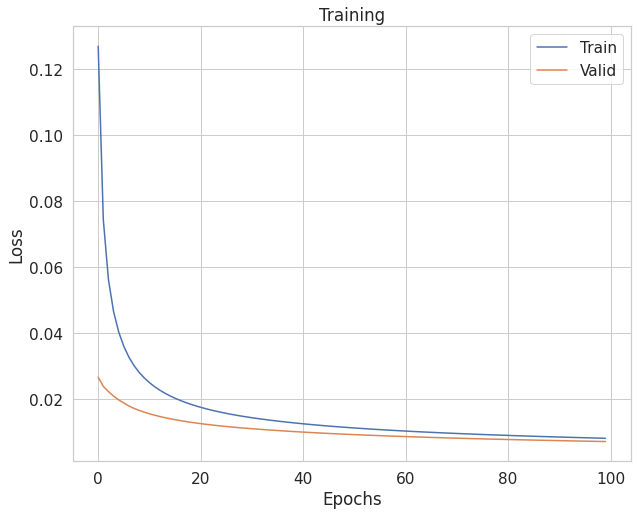

In [21]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (10, 8))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot(train_losses, val_losses)

In [22]:
def visualize(img, model, div_coef=2):
    with torch.no_grad():
        x = torch.flatten(img)
        x = x[None, :]
        latent_code = model.encoder(x.to(device))[0].cpu()

        reco, _ = model(img[None, :, :, :].to(device))
        reco = reco[0].cpu()
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(latent_code.reshape([latent_code.shape[-1]//div_coef,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).permute(1, 2, 0))
    plt.show()

Final MSE: 0.007138175889849663


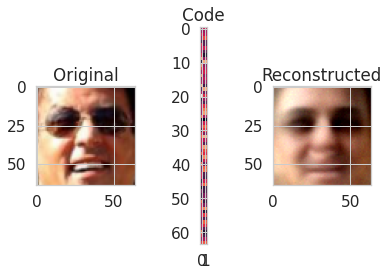

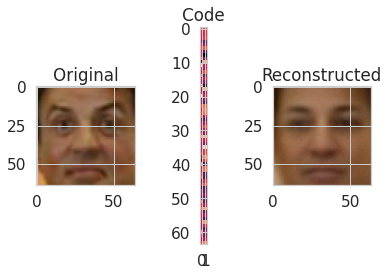

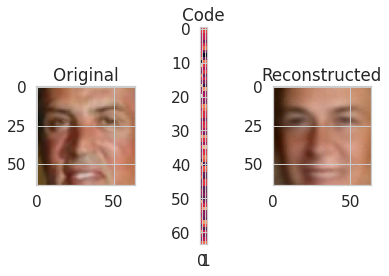

In [23]:
score = val_losses[-1]
print(f'Final MSE: {score}')

for i in range(3):
    img = X_test[i]
    visualize(img, trained_autoencoder)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [24]:
model = trained_autoencoder

for X in test_loader:
  batch = X[0].to(device)
  _, latent_vec = model(batch.to(device))
  break

print(latent_vec.shape)

latent_mean = latent_vec.mean(dim=0)
latent_std = latent_vec.std(dim=0)

latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

print(latent_mean.shape, latent_std.shape)

torch.Size([256, 128])
(128,) (128,)


In [25]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.array([np.random.normal(0, 1, dim_size) for i in range(32)])
z = z * latent_std + latent_mean
print(z.shape)


model.eval()
with torch.no_grad():
    reconstruction = model.sample(torch.FloatTensor(z).to(device))
    reconstruction = reconstruction
    output = reconstruction.cpu().detach().numpy()


(32, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

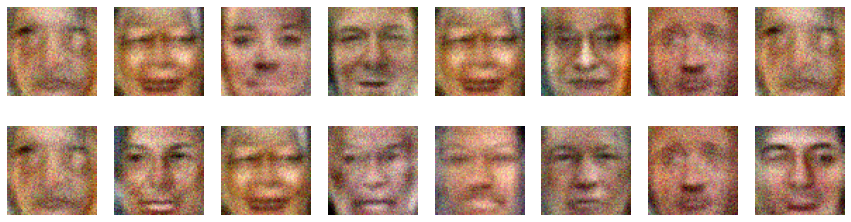

In [26]:
img_show(output)

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Сделаем маску для улыбки. Из всего набора данных отберем картнки с высоким коэффициентом "улыбки". Далее загрузим данные и обучим сеть. 

То же самое проделаем и для "грустных".

Вычтим один из другого и получим вектор улыбок 


In [27]:
model = autoencoder

In [28]:
# улыбки
funny_mask = attrs_train['Smiling'] > 2
funny_people_dl = DataLoader(dataset_train[funny_mask], batch_size=32)

In [29]:
for X in funny_people_dl:
  batch = X[0].to(device)
  _, funny_latent_vec = model(batch.to(device))
  break

print(funny_latent_vec.shape)

torch.Size([316, 128])


In [30]:
# грусть
sad_mask = attrs_train['Smiling'] < -2
sad_people_dl = DataLoader(dataset_train[sad_mask], batch_size=32)

In [31]:
for X in sad_people_dl:
  batch = X[0].to(device)
  _, sad_latent_vec = model(batch.to(device))
  break

print(sad_latent_vec.shape)

torch.Size([228, 128])


In [32]:
# вектор улыбок 
smile_latent_vec = funny_latent_vec.mean(dim=0) - sad_latent_vec.mean(dim=0)

In [33]:
for X in test_loader:
  batch = X[0].to(device)
  _, latent_vec = model(batch.to(device))
  latent_vec += smile_latent_vec # рисуем улыбку
  result = model.sample(latent_vec.to(device))

  result = result.cpu().detach().numpy()
  ground_truth = batch.cpu().detach().numpy()
  break


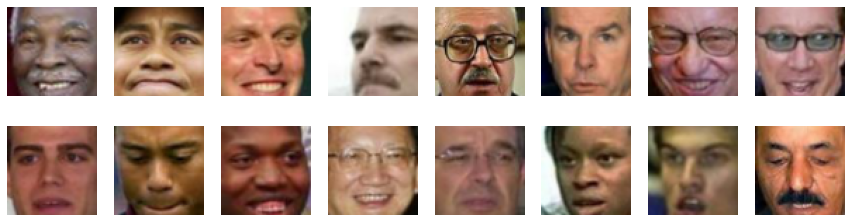

In [34]:
img_show(ground_truth)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

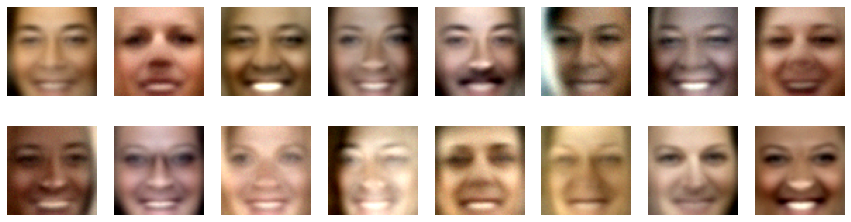

In [35]:
img_show(result)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [36]:
from torchvision import transforms

In [37]:
batch_size = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [38]:
dim_code = 8

In [39]:
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
      
      self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=3),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(in_features=16*24*24, out_features=2*dim_code)
            )

      self.decoder = nn.Sequential(        
            nn.Linear(in_features=dim_code, out_features=16*24*24),
            nn.Unflatten(1, (16, 24, 24)),
            nn.ConvTranspose2d(16,6,kernel_size=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=3),
            nn.Sigmoid()
            )
  

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
      x = self.encoder(x)
      mu, logsigma = torch.split(x, dim_code, dim=1)
      
      return mu, logsigma
        
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
          #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
          std = torch.exp(logsigma)
          eps = torch.randn_like(std)
          sample = eps*std + mu
          return sample
        else:
          # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
          # на инференсе выход автоэнкодера должен быть детерминирован.
          return mu
    

    def decode(self, z):
      # <реализуйте forward проход декодера
      # в качестве возвращаемой переменной -- reconstruction>
      reconstruction = self.decoder(z)
      return reconstruction

    def forward(self, x):
      # <используя encode и decode, реализуйте forward проход автоэнкодера
      # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
      mu , logsigma = self.encode(x)
      latent_code = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decoder(latent_code)

      return mu, logsigma, reconstruction


    def get_latent_vector(self, x):
        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_code, dim=1)
        latent_code = self.gaussian_sampler(mu, logsigma)

        return latent_code


    def sample(self, x):
        generated = self.decoder(x)

        return generated

In [40]:
def train(model, optimizer, criterion, val_loader, n_epochs=50):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        for X_batch, _ in val_loader:
            mu, logsigma, reconstruction = model(X_batch.to(device))
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())


        model.eval()
        with torch.no_grad():
            for X_batch, _ in val_loader:
              mu, logsigma, reconstruction = model(X_batch.to(device))
              loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
              
              val_loss.append(loss.cpu().numpy())
        
        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

    return train_loss_epoch, val_loss_epoch

In [41]:
def show_image(ground_truth, result, img_cnt, start_index=0):
    plt.figure(figsize=(25, 8))
    for k in range(img_cnt):
        plt.subplot(2, img_cnt, k+1)
        plt.imshow(ground_truth[start_index+k].reshape(28, 28), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, img_cnt, k+1+img_cnt)
        plt.imshow(result[start_index+k].reshape(28, 28), cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [42]:
def eval(model, val_loader, start_index=0):
    model.eval()
    with torch.no_grad():
        for X_batch, _ in val_loader:
          mu, logsigma, reconstruction = model(X_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          img_cnt = min(6, X_batch.shape[0])
          break
          
    show_image(ground_truth, result, img_cnt, start_index)


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [43]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [44]:
criterion = loss_vae

vae_autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(vae_autoencoder.parameters(), lr=1e-4)

In [45]:
train_losses, val_losses = train(vae_autoencoder, optimizer, criterion, test_loader, n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

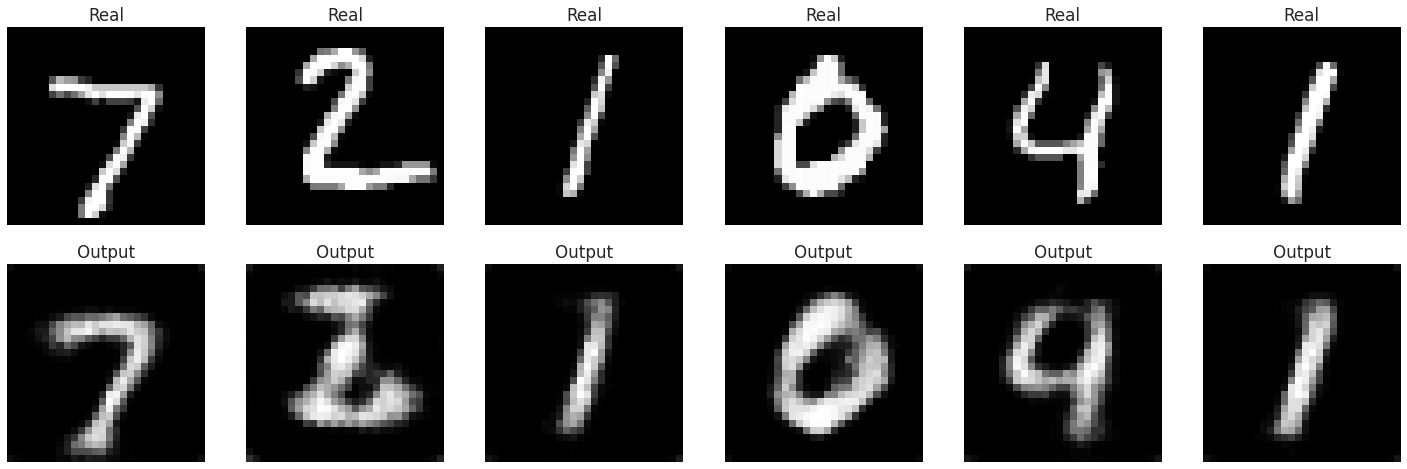

In [46]:
eval(vae_autoencoder, test_loader, start_index=0)

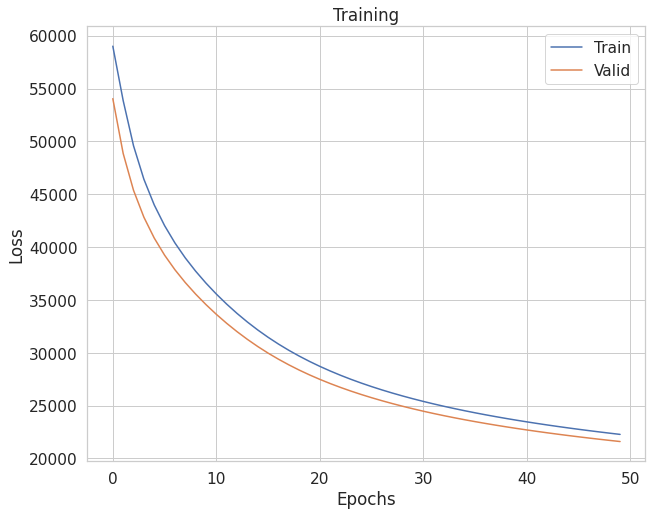

In [47]:
plot(train_losses, val_losses)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [48]:
model = vae_autoencoder

In [49]:
for X_batch, y_batch in test_loader:
    latent_vector = model.get_latent_vector(X_batch.to(device))  
    break  

latent_vector.shape

torch.Size([128, 8])

In [50]:
latent_mean = latent_vector.mean(dim=0)
latent_std = latent_vector.std(dim=0)

latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

latent_mean, latent_std

(array([ 0.32966253,  0.4633856 , -0.5191792 ,  0.53764546,  0.80273753,
        -0.4438022 ,  0.46339795,  0.82888156], dtype=float32),
 array([0.66993445, 0.6618169 , 0.5176652 , 0.75081104, 0.7916466 ,
        0.73586935, 0.7701532 , 0.83150077], dtype=float32))

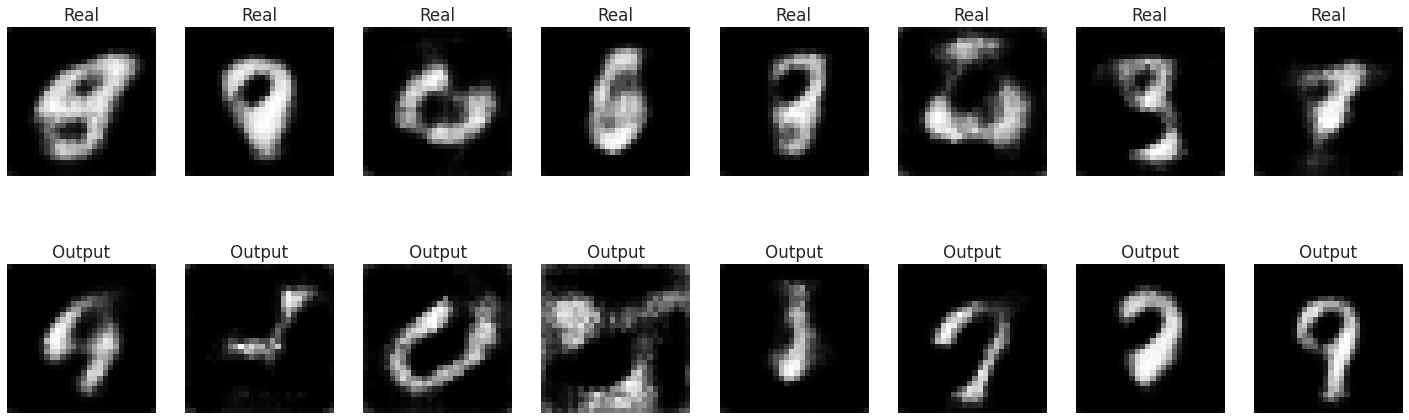

In [51]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(32)])
z = z * latent_std + latent_mean

model.eval()
with torch.no_grad():
    reconstruction = model.sample(torch.FloatTensor(z).to(device))
    output = reconstruction.cpu().detach().numpy()

show_image(output[:16, :, :, :], output[16:, :, :, :], 8)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [52]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
test_loader = iter(test_loader)
X_batch, y_batch = next(test_loader)

In [54]:
latent_vector_list = model.get_latent_vector(X_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in test_loader:
    batch_sample = model.get_latent_vector(X_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [55]:
latent_vector_list.shape

torch.Size([10000, 8])

In [56]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [57]:
from sklearn.manifold import TSNE

In [58]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)

In [59]:
X_embedded[:,0].shape

(10000,)

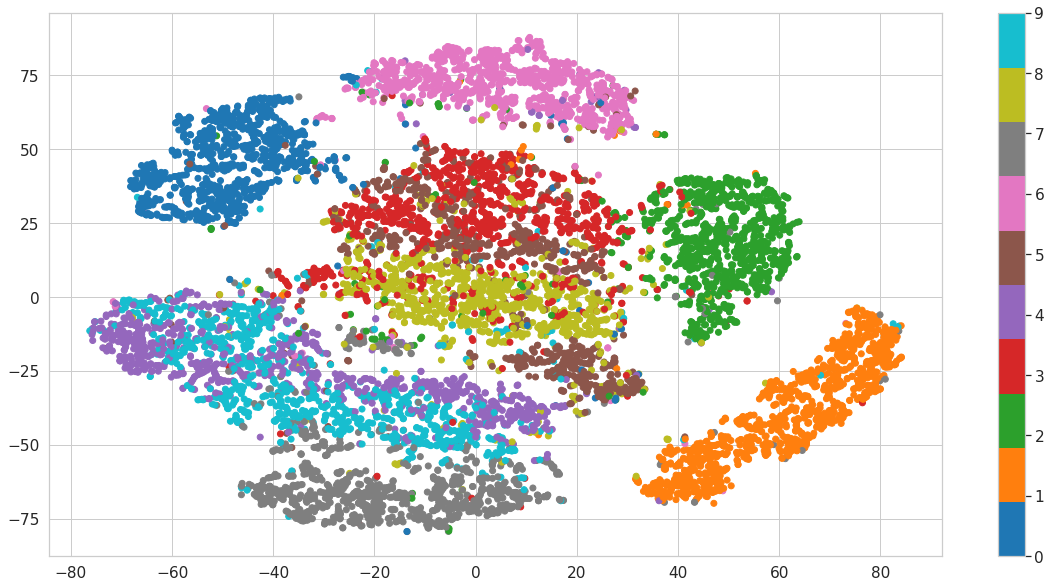

In [60]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [61]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        # encoder
        self.enc_fc1 = nn.Linear(in_features=28*28+10, out_features=128)
        self.enc_ac1 = nn.ReLU()
        self.enc_fc2 = nn.Linear(in_features=128, out_features=64)
        self.enc_ac2 = nn.ReLU()
        self.enc_fc3 = nn.Linear(in_features=64, out_features=2*dim_code)

        # decoder
        self.dec_fc1 = nn.Linear(in_features=dim_code+10, out_features=64)
        self.dec_ac1 = nn.ReLU()
        self.dec_fc2 = nn.Linear(in_features=64, out_features=128)
        self.dec_ac2 = nn.ReLU()
        self.dec_fc3 = nn.Linear(in_features=128, out_features=28*28)
        self.dec_ac3 = nn.Sigmoid()

    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        
        # decoder
        x = x.reshape(-1, 28*28)
        one_hot = F.one_hot(class_num, num_classes=10)
        x = (torch.hstack((one_hot, x))) # stacking 1

        x = self.enc_fc1(x)
        x = self.enc_ac1(x)
        x = self.enc_fc2(x)
        x = self.enc_ac2(x) 
        x = self.enc_fc3(x)

        mu, logsigma = torch.split(x, dim_code, dim=1)

        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(logsigma)
            eps = torch.randn_like(std)
            sample = eps * std + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        
        
        # print('z.shape =', z.shape)
        z = self.dec_ac1(self.dec_fc1(z))
        z = self.dec_ac2(self.dec_fc2(z))
        z = self.dec_fc3(z)
        z = z.view(-1, 1, 28, 28)
        reconstruction = self.dec_ac3(z)
        return reconstruction

    def forward(self, x, y):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        
        mu, logsigma, class_num = self.encode(x, y)
        latent_code = self.gaussian_sampler(mu, logsigma)

        one_hot = F.one_hot(class_num, num_classes=10)
        sample = torch.hstack((one_hot, latent_code))
        # print('forward sample.shape =', sample.shape)
        reconstruction = self.decode(sample) # stacking 2

        return mu, logsigma, reconstruction

    def sample(self, x):
        generated = self.decode(x)
        return generated

    def get_latent_vector(self, x, y):
        mu, logsigma, class_num = self.encode(x, y)
        latent_code = self.gaussian_sampler(mu, logsigma)
        one_hot = F.one_hot(class_num, num_classes=10)
        latent_code = torch.hstack((one_hot, latent_code))
        # print('get_latent latent_code.shape =', latent_code.shape)
        return latent_code

In [63]:
def train(model, optimizer, criterion, val_loader, n_epochs=20):
    
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        for X_batch, y_batch in val_loader:
            mu, logsigma, reconstruction = model(X_batch.to(device), 
                                                 y_batch.to(device))
            
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
              mu, logsigma, reconstruction = model(X_batch.to(device), y_batch.to(device))
              
              loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
              val_loss.append(loss.cpu().numpy())

        
        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

    return train_loss_epoch, val_loss_epoch

In [64]:
def eval(model, val_loader, start_index=0):
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
          mu, logsigma, reconstruction = model(X_batch.to(device), y_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          img_cnt = min(6, X_batch.shape[0])
          break
          
    show_image(ground_truth, result, img_cnt, start_index)

In [65]:
criterion = loss_vae

cv_autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(cv_autoencoder.parameters(), lr=1e-4)

In [66]:
train_losses, val_losses = train(cv_autoencoder, optimizer, criterion, test_loader, n_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

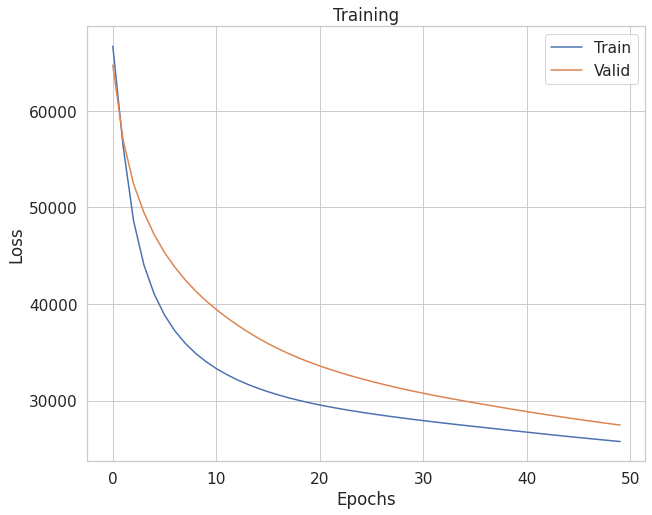

In [67]:
plot(train_losses, val_losses)

# plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
# plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

# plt.xlabel('Epoch')
# plt.title('MSE loss')
# plt.legend()
# plt.show()


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [68]:
model = cv_autoencoder

In [69]:
for X_batch, y_batch in test_loader:
    latent_vector = model.get_latent_vector(X_batch.to(device), y_batch.to(device))  
    break

In [70]:
latent_mean = latent_vector.mean(dim=0)
latent_std = latent_vector.std(dim=0)

latent_mean = latent_mean.cpu().detach().numpy()
latent_std = latent_std.cpu().detach().numpy()

latent_mean.shape, latent_std.shape

((18,), (18,))

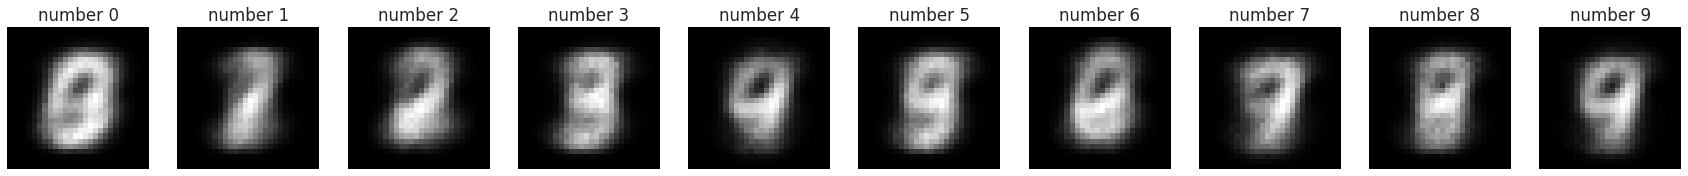

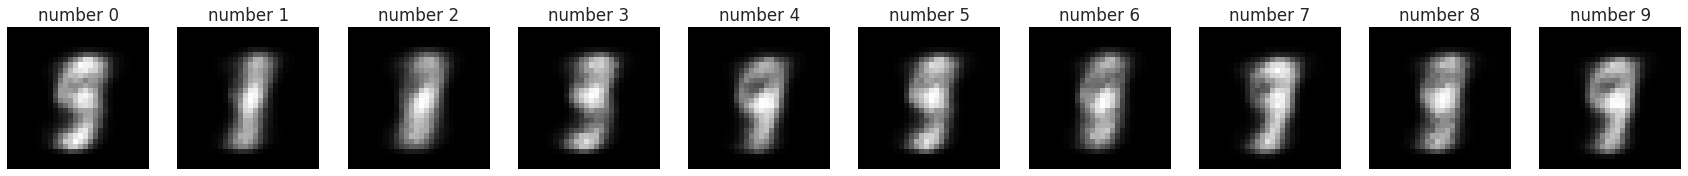

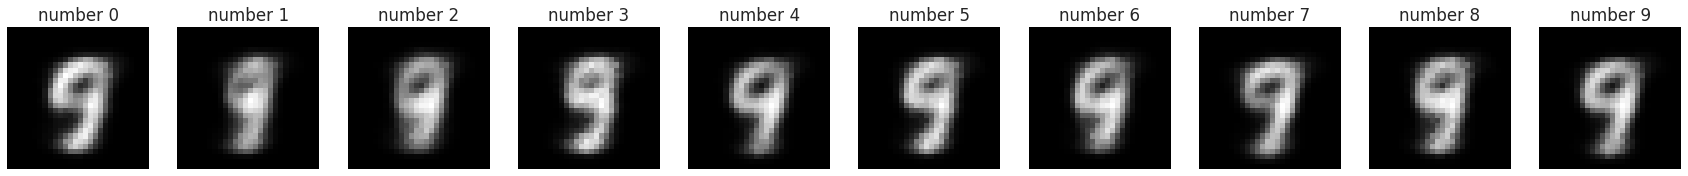

In [71]:
for i in range(3):
    z = np.random.randn(8) * latent_std[10:] + latent_mean[10:]
    z = torch.FloatTensor(z)

    plt.figure(figsize=[30, 20])
    for i in range(10):
        random_latent = torch.hstack((torch.zeros(10), z)).to(device)
        random_latent[i] = 1
        output = model.sample(random_latent).detach().cpu().reshape(28, 28)
        plt.subplot(1, 10, i+1)
        plt.imshow(output, cmap='gray') 
        plt.title(f'number {i}')
        plt.axis('off')
    plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [72]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
test_loader = iter(test_loader)
X_batch, y_batch = next(test_loader)

In [73]:
latent_vector_list = model.get_latent_vector(X_batch.to(device), y_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in test_loader:
    batch_sample = model.get_latent_vector(X_batch.to(device), y_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [74]:
latent_vector_list.shape

torch.Size([10000, 18])

In [75]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [76]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)

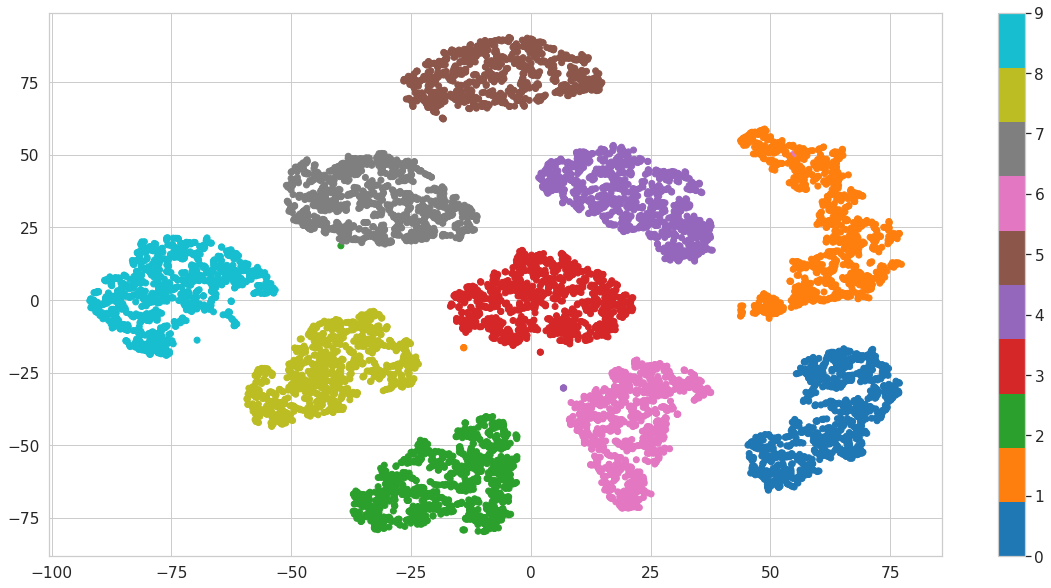

In [77]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

уберем one-hot

In [78]:
latent_vector_list = latent_vector_list[:,10:]

In [79]:
X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
X_embedded.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)

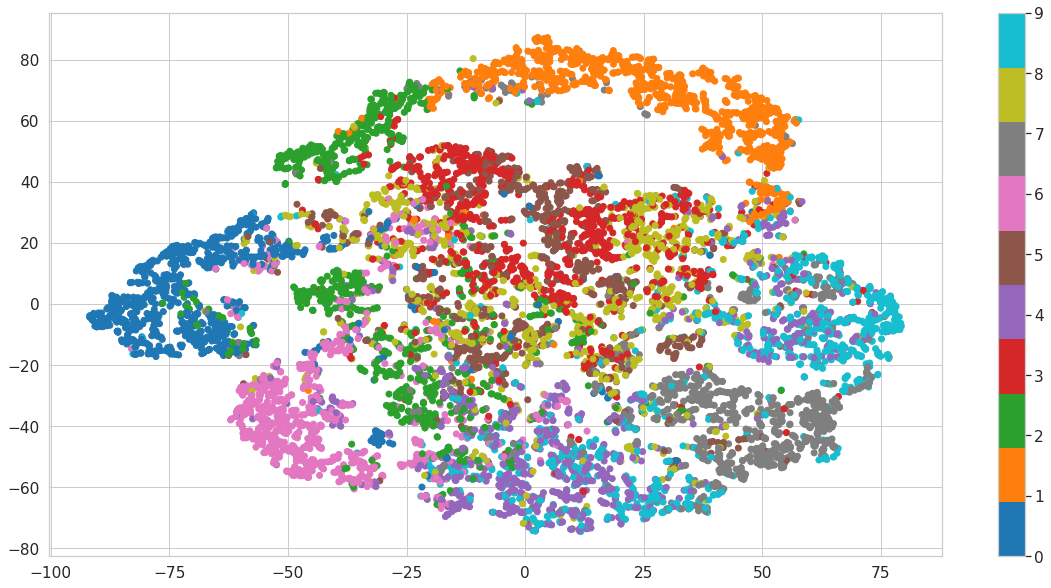

In [80]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(graph)
plt.colormaps()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [81]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [82]:
# Добавляем на картинку немного шума 
def apply_gaussian_noise(X, sigma=0.01):
    return X + sigma * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


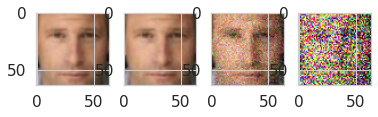

In [83]:
plt.subplot(1,4,1)
plt.imshow(X_train[0].permute(1,2,0))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.01)[0].permute(1,2,0))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.1)[0].permute(1,2,0))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X_train[:1], sigma=0.5)[0].permute(1,2,0));

In [84]:
# Зашумляем данные 
X_train_noisy = apply_gaussian_noise(X_train, sigma=0.1)
X_test_noisy = apply_gaussian_noise(X_test, sigma=0.1)

# Убираем все заскоки за отрезок [0;1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.).type(torch.float32)
X_test_noisy = np.clip(X_test_noisy, 0., 1.).type(torch.float32)

In [85]:
X_test_noisy.dtype

torch.float32

In [86]:
dataset_train = TensorDataset(X_train_noisy, X_train)
dataset_test = TensorDataset(X_test_noisy, X_test)

BATCH_SIZE = 256

train_loader_noise = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader_noise = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)


In [87]:
class DeepAutoencoder(nn.Module):

    def __init__(self, img_shape, code_size=150):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        
        def initialization(layer):
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.)
        
        self.encoder = nn.Sequential(nn.Linear(np.prod(img_shape), code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, code_size))  # Бутылочное горлышко

        self.decoder = nn.Sequential(nn.Linear(code_size, code_size*4),
                                     nn.ReLU(),
                                     nn.Linear(code_size*4, np.prod(img_shape)))
        
        self.apply(initialization)
        
    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code


In [88]:
criterion = torch.nn.MSELoss()

print('input_shape', input_shape)
denoise_autoenc = DeepAutoencoder(input_shape, code_size=1024)
denoise_autoenc.to(device)


optimizer = optim.Adam(denoise_autoenc.parameters(), lr=1e-4)

input_shape torch.Size([3, 64, 64])


In [89]:
def train_denoise(model, train_loader, val_loader, device=device, epochs=50, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X_noizy, X in train_loader:
            batch = X_noizy.to(device)
            target = X.to(device)

            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, target)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X_noizy, X in val_loader:
                batch = X_noizy.to(device)
                target = X.to(device)

                reconstruction, _ = model(batch)
                loss = criterion(reconstruction, target)
                
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 10 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch


In [90]:
path = '/content/gdrive/My Drive/denoise_autoencoder'

denoise_model, denoise_train_loss, denoise_val_loss = train_denoise(denoise_autoenc, 
                                                                    train_loader_noise, test_loader_noise, 
                                                                    device=device, epochs=50, 
                                                                    path=path)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.045274;   val loss: 0.019110
After 10 epochs, training loss: 0.012290;   val loss: 0.009499
After 20 epochs, training loss: 0.008915;   val loss: 0.007488
After 30 epochs, training loss: 0.007364;   val loss: 0.006452
After 40 epochs, training loss: 0.006419;   val loss: 0.005777


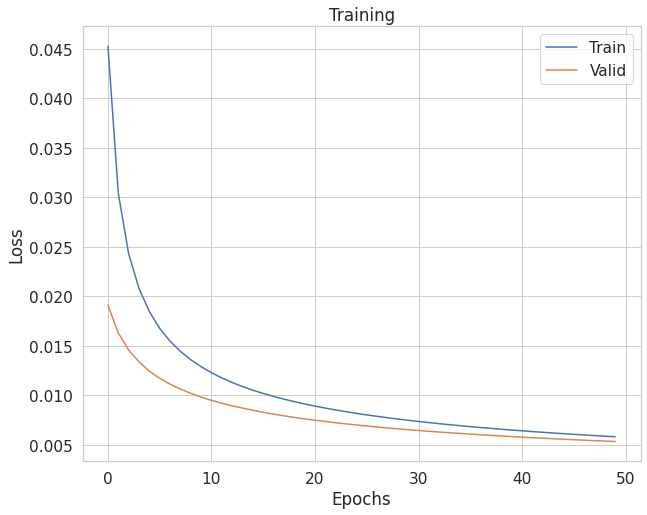

In [91]:
plot(denoise_train_loss, denoise_val_loss)

Final MSE: 0.005336588


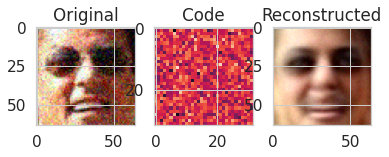

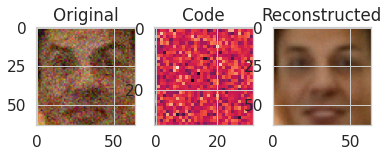

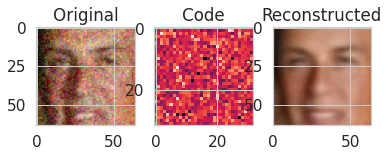

In [92]:
score = denoise_val_loss[-1]
print("Final MSE:",score)

for i in range(3):
    img = X_test_noisy[i]
    visualize(img, denoise_model, div_coef=32)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [93]:
dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

BATCH_SIZE = 128

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [94]:
criterion = torch.nn.MSELoss()

print('input_shape', input_shape)
deepautoencoder = DeepAutoencoder(input_shape)
deepautoencoder.to(device)

optimizer = optim.Adam(deepautoencoder.parameters(), lr=1e-3)

input_shape torch.Size([3, 64, 64])


In [95]:
def train(model, train_loader, val_loader, device=device, epochs=50, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 5 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

        os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [96]:
path = '/content/gdrive/My Drive/deepautoencoder'

deepmodel, deep_train_loss, deep_val_loss = train(deepautoencoder, 
                                                  train_loader, test_loader, 
                                                  device=device, epochs=50, 
                                                  path=path)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.032606;   val loss: 0.014513
After 5 epochs, training loss: 0.013391;   val loss: 0.009929
After 10 epochs, training loss: 0.010470;   val loss: 0.008550
After 15 epochs, training loss: 0.009404;   val loss: 0.008135
After 20 epochs, training loss: 0.008674;   val loss: 0.007714
After 25 epochs, training loss: 0.010016;   val loss: 0.009078
After 30 epochs, training loss: 0.010304;   val loss: 0.009506
After 35 epochs, training loss: 0.010492;   val loss: 0.009789
After 40 epochs, training loss: 0.010626;   val loss: 0.010004
After 45 epochs, training loss: 0.010728;   val loss: 0.010170


In [97]:
def predict(loader=train_loader, device=device):
    deepmodel.eval()

    with torch.no_grad():
        codes = []
        for X in loader:
            batch = X[0].to(device)
            _, latent_code = deepmodel(batch)
            codes.append(latent_code.cpu())

    codes = torch.cat(codes)
    return codes


codes = predict(train_loader)

# хорошая идея ставить по ходу архитекрутуры проверки на размерности :) 
assert len(codes) == len(dataset_train)

In [98]:
print(codes.shape)
codes[0]

torch.Size([11828, 150])


tensor([ 0.7020, -0.6048,  0.4499, -0.2310,  2.7728, -0.1766,  0.8936, -1.5646,
        -1.4290, -0.4369, -2.2459,  0.1929,  0.0520,  0.9332,  0.5036,  2.7647,
        -1.7628, -0.6029, -0.4615,  1.3720, -3.9790,  2.7622,  1.3763, -2.5682,
         0.9258,  0.9306,  0.0322, -0.9468,  0.5446, -0.3015,  2.4612,  0.6746,
         1.2069, -1.0347,  0.4261,  3.9113,  0.2360, -2.9563, -0.6745,  0.6427,
        -0.3837, -3.1778,  0.5859,  0.0962,  1.0480,  2.1031,  0.5485, -1.9487,
         0.5088,  1.4043, -0.8757, -0.1207, -0.5761,  3.9680, -3.6243,  1.7179,
        -0.5238, -3.2192,  0.5778,  1.5829, -2.3482, -1.4409, -1.5549, -0.3032,
        -1.1773,  0.0289,  0.4559,  1.2259, -0.3219, -0.9225, -1.0554, -0.0442,
         0.9381, -0.4360,  1.7747, -0.6201, -0.4882,  0.7368, -0.9230,  0.0062,
        -0.2181, -2.2598, -0.9151, -2.3221,  2.5186,  0.5531, -2.4876, -2.9768,
        -3.9712, -4.2174,  0.7920, -2.7534,  0.7628,  0.7459, -3.0242, -0.7531,
        -0.0434, -0.6430, -0.7183, -0.71

In [99]:
from sklearn.neighbors import NearestNeighbors

def get_similar(image, all_images, codes, model, n_neighbors=5, get_random=False):
    nn = NearestNeighbors(n_neighbors=50).fit(codes)  # nn is not a Neural Network; do not mess up!

    with torch.no_grad():
        x = torch.flatten(image)
        x = x[None, :]
        latent_code = model.encoder(x.to(device)).cpu()
    (distances,), (idx,) = nn.kneighbors(latent_code, n_neighbors=n_neighbors)

    return distances, all_images[idx]

In [100]:
def show_similar(image, all_images, codes, model=deepautoencoder, n_neighbors=11):
    
    distances, neighbors = get_similar(image, all_images, codes, model, n_neighbors=n_neighbors)
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3, 4, i+2)
        plt.imshow(neighbors[i].permute(1, 2, 0))
        plt.title(f"Dist={distances[i]:.3f}")
        
    plt.tight_layout()        
    plt.show()

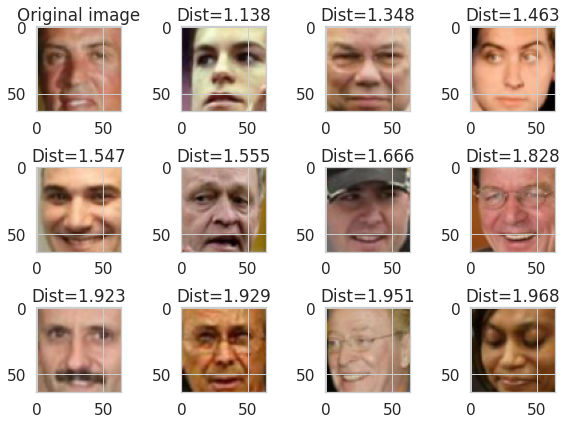

In [101]:
show_similar(X_test[2], X_train, codes, deepautoencoder)

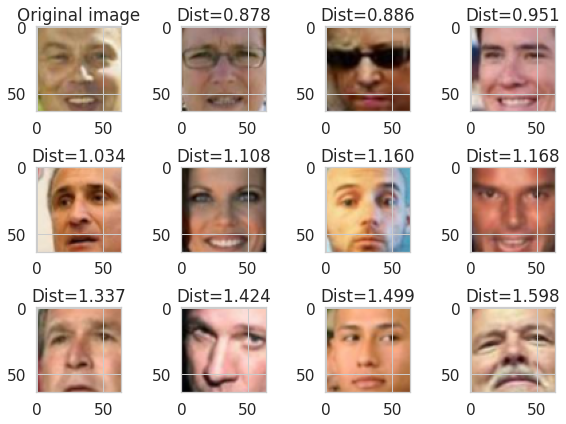

In [102]:
show_similar(X_test[500], X_train, codes, deepautoencoder)

In [103]:
X_train.shape

torch.Size([11828, 3, 64, 64])